In [1]:
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Markdown, display

## Overview
Our approach is composed of two phases: **Offline Pre-training** and **Online Learning**. 

In the offline pre-training phase, the agent is initialized by observing and learning from historical data of the existing controller. Such data is typically logged in Building Automation System (BAS) and readily available. 

Then, in the online learning phase, the agent is put in charge of controlling the environment. Since, the Gnu-RL agent is pretrained with the historical state-action pair of the existing controller, it behaves similarly to the existing controller. It updates its policy over time with new observations, and thus improve upon the existing controller.  

<img src="images/framework.png">


## Simulation Testbed
We compare two control strategies, a baseline EnergyPlus control and our proposed Gru-RL control. 

In the **Offline Pretraining** phase, we use a baseline EnergyPlus controller to simulate state-action pairs as expert demonstration and initialize the Gru-RL agent by imitating the behaviours of the baseline EnergyPlus controller. 

In the **Online Learning** phase, we put the initialized Gru-RL agent in charge of controlling the environment and compare its performance to that of the baseline EnergyPlus controller. 

We use two different weather sequences, TMY2 and TMY3, for **Offline Pretraining** and **Online Learning** respectively. The simulation runs from Jan. 1 to Mar. 31 based on Pittsburgh weather.  

The environments and their corresponding files are listed below.  

| **Environment Name** |**Model File (\*.idf)**|**Configuration File (\*.cfg)**|**Weather File (\*.epw)**| **Description**|
|:----------------|:---------------|:--------|:-----------|:--------------------------------|
|**5Zone-sim_TMY2-v0**|5Zone_Default.idf|variables_Default.cfg|pittsburgh_TMY2.epw|Baseline EnergyPlus control; Used for expert demonstration in offline pretraining|
|**5Zone-control_TMY3-v0**|5Zone_Control.idf|variables_Control.cfg|pittsburgh_TMY3.epw|Gru-RL control; Used in online learning|
| **5Zone-sim_TMY3-v0**   | 5Zone_Default.idf|variables_Default.cfg|pittsburgh_TMY3.epw|Baseline EnergyPlus control; Used for performance comparison|

 

### Model Description
The EnergyPlus model used for this demo was modified from *5ZoneAutoDXVAV.idf* in the example files included with EnergyPlus installation. It models a 463.6 $m^2$ single-floor rectangular building located in Pittsburgh. The space is partitioned into five thermal zones, i.e. one core zone and four permeter zones. The internal surfaces between the thermal zones are modeled with [IRTSurface](https://bigladdersoftware.com/epx/docs/8-0/engineering-reference/page-023.html), which has no thermal resistance and is transparent to infrared radiation. 

<img src="images/5Zone.png">

### HVAC
Since the simulation runs from Jan. 1 to Mar. 31 based on Pittsburgh weather, we do not consider cooling in this demonstration. 

The air conditioning to the building is supplied by an air handling unit (AHU) with a variable speed fan. The heating is provided by a main heating coil in the air handling unit. The reheat coils in each thermal zone are deactivated for the purpose of this demonstration. That is to say, the only source of heating is the main heating coil.

The terminal unit in each thermal zone controls the air flow rate based on single maximum control logic. Specifically, the airflow rate is kept at the minimum that satisfy outdoor air requirements during the heating mode. The terminal unit takes in extra outdoor air for free cooling when the indoor air temperature gets too warm.

### Control
In this demonstration, we control the supply air temperature of the main AHU and let the terminal units determine the airflow based on default EnergyPlus control logic. In the baseline EnergyPlus control, we use the predefined [**SetpointManager:MultiZone:Heating:Average**](https://bigladdersoftware.com/epx/docs/8-0/input-output-reference/page-050.html#setpointmanagermultizoneheatingaverage) object. In the Gnu-RL control, the action is defined as the difference between Supply Air Temperature and Mixed Air Temperature, which is proportional to the energy consumption of the heating coil. The supply air temperature is then calculated and passed to EnergyPlus through the *Gym-Eplus* interface. 

### State-Action Space
**State:**
- Indoor Temp.

**Setpoint:**
- Indoor Temp. Setpoint

**Action:**
- Temperature difference between Supply Air and Mixed Air

**Disturbance:**
- Outdoor Temp.
- Outdoor RH 
- Wind Speed
- Wind Direction 
- Diff. Solar Rad.
- Direct Solar Rad.
- Occupancy Flag


## Step 1: Offline Pretraining

- Expert: Baseline EnergyPlus controller (SetpointManager:MultiZone:Heating:Average)
- Learner: Gru-RL agent
- Weather Sequence: Pittsburgh TMY2

In the **Offline Pretraining** phase, the Gru-RL agent imitates the behaviours of the expert, i.e. the baseline EnergyPlus controller, by minimizing the imitation loss, $\mathcal{L}_{\text{Imit}}(\theta)$. The hyperparameter $\lambda$ balances the relative importance of states and actions. In this demo, we use $\lambda =10$, because we are more concerned about Gru-RL agent learning environment dynamics, then copying the baseline EnergyPlus controller's actions. 

$$\mathcal{L}_{\text{Imit}}(\theta) =  \sum_t \lambda(x_t-\hat{x}_t)^2+(u_t-\hat{u}_t)^2$$

One thing to note it that the Gru-RL agent does not interact with the environment in the offline pretraining phase. 


**Observation:**
The Gru-RL agent learns to predict next state reasonably well after the pretraining. 


In [2]:
filePath = "./results/"
imit_record = pd.read_pickle(filePath+"Imit_rl.pkl")

In [3]:
imit_record["Hour"] = pd.Series([time.hour for time in imit_record.index], index = imit_record.index)
imit_record["Occupancy Flag"] = (imit_record["Hour"]>=8) & (imit_record["Hour"]< 18)
imit_record["Indoor Temp. Setpoint"] = pd.Series([22.5 if occupied==1 else 12.8 for occupied in imit_record["Occupancy Flag"]], index = imit_record.index)

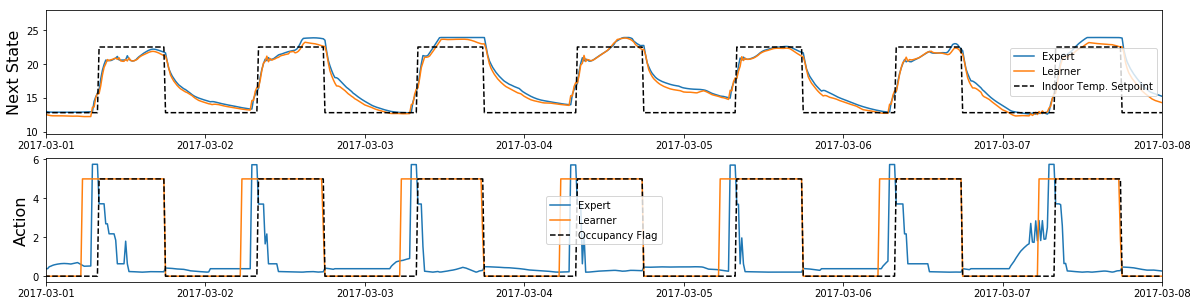

In [15]:
start_time = pd.datetime(year = 2017, month = 3, day = 1)
end_time = start_time + pd.Timedelta(days = 7)

fig = plt.figure(figsize=(20,5))
plt.subplot(2,1,1)
plt.plot(imit_record["Expert nState"], label = "Expert")
plt.plot(imit_record["Learner nState"], label = "Learner")
plt.plot(imit_record["Indoor Temp. Setpoint"], "k--", label = "Indoor Temp. Setpoint")
plt.ylabel("Next State", fontsize = 16)
plt.xlim((start_time, end_time))
plt.legend()

plt.subplot(2,1,2)
plt.plot(imit_record["Expert action"], label = "Expert")
plt.plot(imit_record["Learner action"], label = "Learner")
plt.plot(imit_record["Occupancy Flag"]*5, 'k--', label = "Occupancy Flag")
plt.ylabel("Action", fontsize = 16)
plt.xlim((start_time, end_time))
plt.legend()

## Step 2: Online Learning

In [3]:
baseline = pd.read_pickle(filePath+"Sim-TMY3.pkl")
baseline["Delta T"] = baseline["Sys Out Temp."] - baseline["MA Temp."]
rl = pd.read_pickle(filePath+"perf_rl_obs.pkl")
rl_action = pd.read_pickle(filePath+"perf_rl_actions.pkl")
rl = rl.merge(rl_action, left_index = True, right_index = True)

### Summary Statistics
**Conclusion:**
The Gru-RL agent saves 10.4% of the energy consumed by the heating coil and 5.3% of the overall HVAC energy consumption compared to the baseline EnergyPlus controller, while maintaining similar level of thermal comfort.  

In [6]:
def CalcStatistics(obs):
    # PPD during Occipied period
    meanPPD = np.mean(obs[obs["Occupancy Flag"]==1]["PPD"])
    print("Average PPD = ", meanPPD)
    
    CoilPower = np.sum(obs["Coil Power"]) # Unit in W
    CoilEnergy = CoilPower*900/1000/3600 # Unit in kWh
    print("Energy Consumed by the Heating Coil = {:.2f}kWh".format(CoilEnergy))
    
    HVACPower = np.sum(obs["HVAC Power"]) # Unit in W
    HVACEnergy = HVACPower*900/1000/3600 # Unit in kWh
    print("Energy Consumed by the HVAC = {:.2f}kWh".format(HVACEnergy))

In [7]:
def printmd(string):
    display(Markdown(string))

In [8]:
printmd("**EnergyPlus Baseline**")
CalcStatistics(baseline)
printmd("**Gnu-RL**")
CalcStatistics(rl)

**EnergyPlus Baseline**

Average PPD =  17.74822905353781
Energy Consumed by the Heating Coil = 4413.17kWh
Energy Consumed by the HVAC = 7482.66kWh


**Gru-RL**

Average PPD =  17.418457774386937
Energy Consumed by the Heating Coil = 3951.23kWh
Energy Consumed by the HVAC = 7088.52kWh


In [9]:
(4413.17-3951.23)/4413.17

0.10467305814187988

In [10]:
(7482.66-7088.52)/7482.66

0.05267378178348334

### At the beginning of training phase:
**Observations:** 
- The Gnu-RL agent behaves similarly to the existing controller before any interaction with the environment is necessary.
- The baseline EnergyPlus controller maintains the indoor air temperature at a shallow setback at night, which consumes energy unnecessarily. The Gnu-RL agent allows the indoor air temperature to drop lower during unoccupied period, conserving energy. 
- The baseline EnergyPlus controller preheats the space one hour prior to occupancy in the morning. The Gnu-RL agent preheats the space based on its predictive model. However, it initially underestimates the amount of preheating required. 

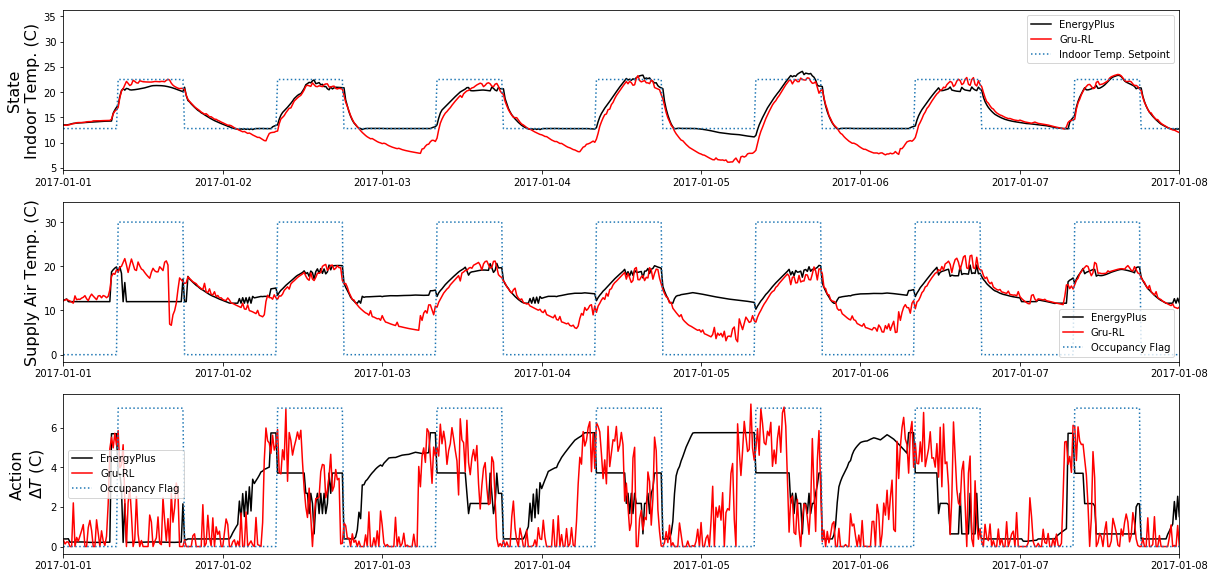

In [11]:
fig = plt.figure(figsize=(20,10))
start_time = pd.datetime(year = 2017, month = 1, day = 1)
end_time = start_time + pd.Timedelta(days = 7)

plt.subplot(3,1,1)
plt.plot(baseline["Indoor Temp."], 'k-', label="EnergyPlus")
plt.plot(rl["Indoor Temp."],'r-', label="Gnu-RL")
plt.plot(rl["Indoor Temp. Setpoint"], ":")
plt.legend()
plt.ylabel("State\nIndoor Temp. (C)", fontsize = 16)
plt.xlim([start_time, end_time])

plt.subplot(3,1,2)
plt.plot(baseline["Sys Out Temp."],'k', label ="EnergyPlus")
plt.plot(rl["Sys Out Temp."], 'r', label ="Gnu-RL")
plt.plot(baseline["Occupancy Flag"]*30, ":", label= "Occupancy Flag")
plt.xlim([start_time, end_time])
plt.ylabel("Supply Air Temp. (C)", fontsize = 16)
plt.legend()

plt.subplot(3,1,3)
plt.plot(baseline["Delta T"],'k', label ="EnergyPlus")
plt.plot(rl["Delta T"], 'r', label ="Gnu-RL")
plt.plot(baseline["Occupancy Flag"]*7, ":", label= "Occupancy Flag")
plt.xlim([start_time, end_time])
plt.ylabel("Action\n$\Delta T$ (C)", fontsize = 16)
plt.legend()

### Compare the Reward between GruRL and baseline EnergyPlus policy
Residue Reward is the difference between the rewards of GruRL and that of the EnergyPlus policy. 

In [12]:
def CalReward(df, eta):
    df["eta"] = pd.Series([eta[int(occupied)] for occupied in df["Occupancy Flag"]], index = df.index)
    df["Reward"] = - 0.5 * df["eta"] * (df["Indoor Temp."] - df["Indoor Temp. Setpoint"])**2 - df["Delta T"]
    return df

eta = [0.1, 4]

rl = CalReward(rl, eta)
baseline = CalReward(baseline, eta)

In [13]:
ResReward = pd.DataFrame(rl["Reward"]-baseline["Reward"])

ResReward["Day"] = pd.Series([time.day for time in ResReward.index], index = ResReward.index)
ResReward["Month"] = pd.Series([time.month for time in ResReward.index], index = ResReward.index)
mean = ResReward.groupby(["Month", "Day"]).mean()
std = ResReward.groupby(["Month", "Day"]).std()

index = pd.date_range(start='1/1/2017', end='3/31/2017')
RewardStats = pd.DataFrame(np.concatenate([mean.values[:90], std.values[:90]], axis =1), index = index, columns = ["Mean", "Std"])

In [3]:
fig = plt.figure(figsize=(10, 4))

start_time = pd.datetime(year = 2017, month = 1, day = 1)
end_time =pd.datetime(year = 2017, month = 3, day = 31)

plt.plot(RewardStats["Mean"])
plt.fill_between(RewardStats.index, RewardStats["Mean"]-1.645*RewardStats["Std"], RewardStats["Mean"]+1.645*RewardStats["Std"], alpha = 0.2)

plt.plot((start_time, end_time), (0, 0), 'k--')

plt.xlim((start_time, end_time))
plt.ylim((-10, 4))

plt.ylabel("Residual Reward", fontsize = 20)

NameError: name 'RewardStats' is not defined

## EDA, Delete for Public Github

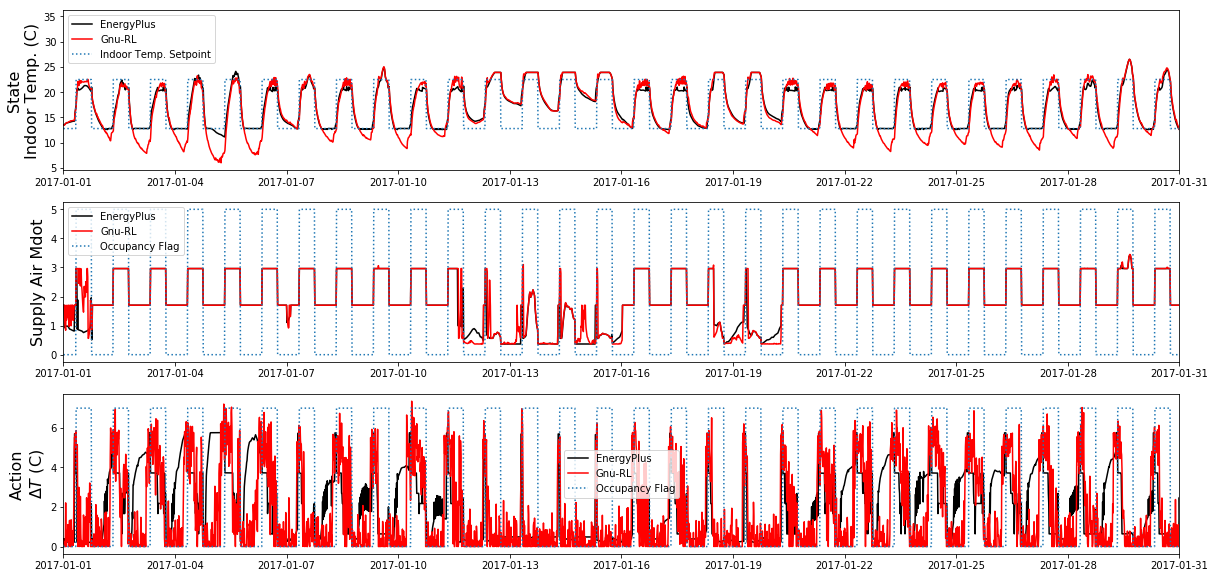

In [10]:
fig = plt.figure(figsize=(20,10))
start_time = pd.datetime(year = 2017, month = 1, day = 1)
end_time = start_time + pd.Timedelta(days = 30)

plt.subplot(3,1,1)
plt.plot(baseline["Indoor Temp."], 'k-', label="EnergyPlus")
plt.plot(rl["Indoor Temp."],'r-', label="Gnu-RL")
plt.plot(rl["Indoor Temp. Setpoint"], ":")
plt.legend()
plt.ylabel("State\nIndoor Temp. (C)", fontsize = 16)
plt.xlim([start_time, end_time])

plt.subplot(3,1,2)
plt.plot(baseline["Sys Out Mdot"],'k', label ="EnergyPlus")
plt.plot(rl["Sys Out Mdot"], 'r', label ="Gnu-RL")
plt.plot(baseline["Occupancy Flag"]*5, ":", label= "Occupancy Flag")
plt.xlim([start_time, end_time])
plt.ylabel("Supply Air Mdot", fontsize = 16)
plt.legend()

plt.subplot(3,1,3)
plt.plot(baseline["Delta T"],'k', label ="EnergyPlus")
plt.plot(rl["Delta T"], 'r', label ="Gnu-RL")
plt.plot(baseline["Occupancy Flag"]*7, ":", label= "Occupancy Flag")
plt.xlim([start_time, end_time])
plt.ylabel("Action\n$\Delta T$ (C)", fontsize = 16)
plt.legend()